# Toolwindow Usage Analysis

## Objective
Analyze whether there's a meaningful difference in how long the tool window stays open depending on whether it was opened manually or automatically.

---

## 1. Setup and Data Loading

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [24]:
# Load the data
df = pd.read_csv('toolwindow_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (3503, 4)

First few rows:


,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5


In [25]:
# Basic data exploration
print("Dataset Info:")
df.info()
print("\n\n")
print("Descriptive Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  3503 non-null   int64 
 1   event      3503 non-null   object
 2   open_type  1865 non-null   object
 3   user_id    3503 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 109.6+ KB



Descriptive Statistics:


,timestamp,user_id
count,3.503000e+03,3503.000000
mean,1.752371e+12,53.521267
std,4.671615e+08,48.532132
min,1.751580e+12,1.000000
25%,1.751991e+12,17.000000
50%,1.752250e+12,35.000000
75%,1.752735e+12,79.500000
max,1.753312e+12,205.000000


In [26]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

print("Unique Values:")
print(f"Events: {df['event'].unique()}")
print(f"Event counts: {df['event'].value_counts().to_dict()}")
print(f"\nOpen types: {df['open_type'].dropna().unique()}")
print(f"Open type counts: {df['open_type'].value_counts().to_dict()}")
print(f"\nUnique users: {df['user_id'].nunique()}")

Missing Values:
timestamp       0
event           0
open_type    1638
user_id         0
dtype: int64
Unique Values:
Events: ['opened' 'closed']
Event counts: {'opened': 1865, 'closed': 1638}

Open types: ['manual' 'auto']
Open type counts: {'auto': 1204, 'manual': 661}

Unique users: 205


---

## 2. Data Cleaning and Preparation

### Strategy for Handling Messy Data

**Challenges identified:**
- Orphaned close events (close without prior open)
- Multiple consecutive opens without closes
- Unclosed opens (still open at dataset end)

**Approach:**
1. Sort events by user_id and timestamp
2. For each user, match open/close pairs chronologically
3. When multiple opens occur, keep only the last one before a close
4. Discard orphaned closes and unclosed opens

In [27]:
# Sort data by user and timestamp
df_sorted = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# Examine a sample user to see data messiness
sample_user = 3
print(f"Sample of events for user_id={sample_user}:")
df_sorted[df_sorted['user_id'] == sample_user].head(15)

Sample of events for user_id=3:


,timestamp,event,open_type,user_id
32,1752240576228,opened,auto,3
33,1752241995868,closed,NaN,3
34,1752242482004,opened,auto,3
35,1752246787053,closed,NaN,3
36,1752246933576,opened,auto,3
37,1752258007775,closed,NaN,3
38,1752269809436,opened,auto,3
39,1752304475081,closed,NaN,3
40,1752304493423,opened,auto,3
41,1752304510989,closed,NaN,3


In [28]:
def match_open_close_pairs_with_tracking(user_events):
    previous_action = None
    user_actions = []
    pending_opens = []  # Track all opens waiting for a close
    
    for idx, (_, action) in enumerate(user_events.iterrows()):
        if action['event'] == 'opened':
            # Add this open to pending list
            pending_opens.append({
                'user_id': action['user_id'],
                'open_timestamp': action['timestamp'],
                'open_type': action['open_type']
            })
        else:  # action is 'closed'
            # Check if previous was also closed - if so, ignore
            if previous_action is not None and previous_action['event'] == 'closed':
                continue
            
            # Fill durations for all pending opens (going in reverse order)
            close_timestamp = action['timestamp']
            for open_event in reversed(pending_opens):
                action_to_append = {
                    'user_id': open_event['user_id'],
                    'open_timestamp': open_event['open_timestamp'],
                    'close_timestamp': close_timestamp,
                    'open_type': open_event['open_type'],
                    'duration_ms': close_timestamp - open_event['open_timestamp']
                }
                user_actions.append(action_to_append)
            
            # Clear pending opens after processing
            pending_opens = []
        
        previous_action = action
    
    # Ignore any remaining unclosed opens (discard pending_opens)
    return user_actions


# Apply matching logic to each user
df_sorted = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
newdf_list = []
for user_id in df_sorted['user_id'].unique():
    user_events = df_sorted[df_sorted['user_id'] == user_id]
    user_actions = match_open_close_pairs_with_tracking(user_events)
    newdf_list.extend(user_actions)

# Create DataFrame
newdf = pd.DataFrame(newdf_list)

# Add duration columns in different units
newdf['duration_seconds'] = newdf['duration_ms'] / 1000
newdf['duration_minutes'] = newdf['duration_seconds'] / 60
newdf['duration_hours'] = newdf['duration_minutes'] / 60

# Add human-readable timestamp columns
newdf['open_date'] = pd.to_datetime(newdf['open_timestamp'], unit='ms')
newdf['close_date'] = pd.to_datetime(newdf['close_timestamp'], unit='ms')

print("\n" + "="*70)
print("DATA MATCHING RESULTS")
print("="*70)
print(f"Total events: {len(df):,}")
print(f"Total opened events: {len(df[df['event'] == 'opened']):,}")
print(f"Total closed events: {len(df[df['event'] == 'closed']):,}")
print(f"\nSuccessfully matched open/close pairs: {len(newdf):,}")

unmatched = len(df[df['event'] == 'opened']) - len(newdf)
print(f"Unmatched opens: {unmatched} ({unmatched/len(df[df['event'] == 'opened'])*100:.1f}%)")
print(f"Data retention: {len(newdf)/len(df[df['event'] == 'opened'])*100:.1f}% of opens successfully matched")

print(f"\nSample of matched sessions:")
newdf.head(10)


DATA MATCHING RESULTS
Total events: 3,503
Total opened events: 1,865
Total closed events: 1,638

Successfully matched open/close pairs: 1,800
Unmatched opens: 65 (3.5%)
Data retention: 96.5% of opens successfully matched

Sample of matched sessions:


,user_id,open_timestamp,close_timestamp,open_type,duration_ms,duration_seconds,duration_minutes,duration_hours,open_date,close_date
0,1,1751826102123,1751826746077,auto,643954,643.954,10.732567,0.178876,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077
1,1,1751841258635,1751849544609,manual,8285974,8285.974,138.099567,2.301659,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609
2,1,1751985487772,1751986623885,manual,1136113,1136.113,18.935217,0.315587,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885
3,1,1752250204033,1752250204781,manual,748,0.748,0.012467,0.000208,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781
4,1,1752250205587,1752257432775,manual,7227188,7227.188,120.453133,2.007552,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775
5,1,1752843408702,1752843421856,manual,13154,13.154,0.219233,0.003654,2025-07-18 12:56:48.702,2025-07-18 12:57:01.856
6,1,1752843424801,1752845073719,manual,1648918,1648.918,27.481967,0.458033,2025-07-18 12:57:04.801,2025-07-18 13:24:33.719
7,1,1752877044540,1752884541824,manual,7497284,7497.284,124.954733,2.082579,2025-07-18 22:17:24.540,2025-07-19 00:22:21.824
8,1,1753104440917,1753106844951,manual,2404034,2404.034,40.067233,0.667787,2025-07-21 13:27:20.917,2025-07-21 14:07:24.951
9,2,1751656141008,1751656199632,auto,58624,58.624,0.977067,0.016284,2025-07-04 19:09:01.008,2025-07-04 19:09:59.632


In [29]:
df[df['user_id'] == 35].sort_values('timestamp').reset_index(drop = True)

,timestamp,event,open_type,user_id
0,1752321348075,opened,manual,35
1,1752321421821,closed,NaN,35
2,1752321423987,opened,manual,35
3,1752321447465,opened,auto,35
4,1752321462324,opened,auto,35
5,1752321476754,closed,NaN,35
6,1752321480371,opened,manual,35
7,1752321630699,closed,NaN,35
8,1752321780579,opened,manual,35
9,1752321783061,closed,NaN,35


In [30]:
# Verify matching results for sample user
print("Sample sessions for user_id=35:")
newdf[newdf['user_id'] == 35].sort_values('open_timestamp')

Sample sessions for user_id=35:


,user_id,open_timestamp,close_timestamp,open_type,duration_ms,duration_seconds,duration_minutes,duration_hours,open_date,close_date
889,35,1752321348075,1752321421821,manual,73746,73.746,1.229100,0.020485,2025-07-12 11:55:48.075,2025-07-12 11:57:01.821
892,35,1752321423987,1752321476754,manual,52767,52.767,0.879450,0.014658,2025-07-12 11:57:03.987,2025-07-12 11:57:56.754
891,35,1752321447465,1752321476754,auto,29289,29.289,0.488150,0.008136,2025-07-12 11:57:27.465,2025-07-12 11:57:56.754
890,35,1752321462324,1752321476754,auto,14430,14.430,0.240500,0.004008,2025-07-12 11:57:42.324,2025-07-12 11:57:56.754
893,35,1752321480371,1752321630699,manual,150328,150.328,2.505467,0.041758,2025-07-12 11:58:00.371,2025-07-12 12:00:30.699
894,35,1752321780579,1752321783061,manual,2482,2.482,0.041367,0.000689,2025-07-12 12:03:00.579,2025-07-12 12:03:03.061
895,35,1752321837094,1752321862711,manual,25617,25.617,0.426950,0.007116,2025-07-12 12:03:57.094,2025-07-12 12:04:22.711
896,35,1752322801797,1752322810596,manual,8799,8.799,0.146650,0.002444,2025-07-12 12:20:01.797,2025-07-12 12:20:10.596
897,35,1752325055342,1752325055991,manual,649,0.649,0.010817,0.000180,2025-07-12 12:57:35.342,2025-07-12 12:57:35.991
898,35,1752326830476,1752326944060,manual,113584,113.584,1.893067,0.031551,2025-07-12 13:27:10.476,2025-07-12 13:29:04.060


### Define missclicks

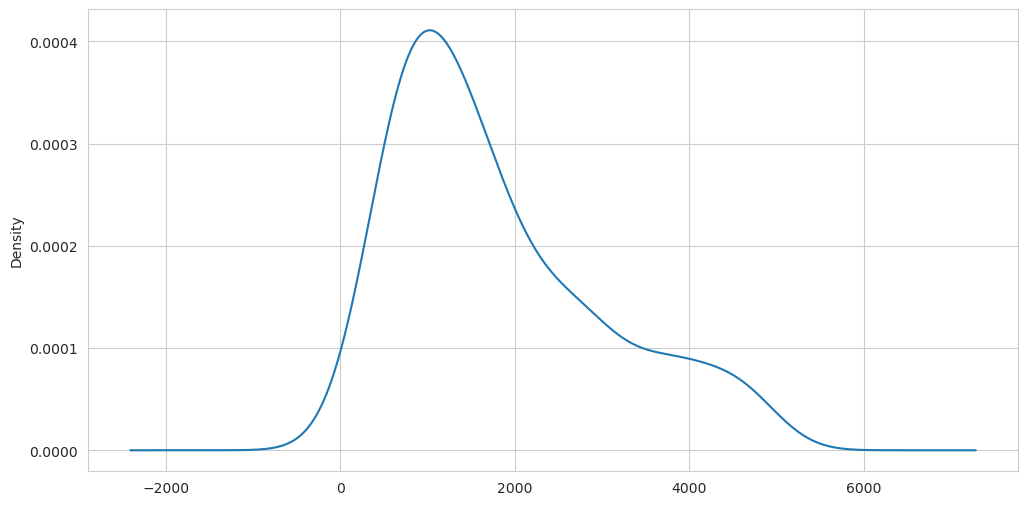

In [ ]:
s = newdf[(newdf['open_type']=='manual') & (newdf['duration_ms']<5000)]['duration_ms'] # < 5 sec
s.plot.density()
plt.show()

In [128]:
newdf['missclick'] = 0
newdf.loc[
    (newdf['open_type'] == 'manual') & (newdf['duration_ms'] < 2000),
    'missclick'
] = 1
newdf[newdf['missclick'] == 1]

,user_id,open_timestamp,close_timestamp,open_type,duration_ms,duration_seconds,duration_minutes,duration_hours,open_date,close_date,missclick
3,1,1752250204033,1752250204781,manual,748,0.748,0.012467,0.000208,2025-07-11 16:10:04.033,2025-07-11 16:10:04.781,1
11,2,1751656665251,1751656665917,manual,666,0.666,0.011100,0.000185,2025-07-04 19:17:45.251,2025-07-04 19:17:45.917,1
12,2,1751820297742,1751820298770,manual,1028,1.028,0.017133,0.000286,2025-07-06 16:44:57.742,2025-07-06 16:44:58.770,1
14,2,1751836139906,1751836141616,manual,1710,1.710,0.028500,0.000475,2025-07-06 21:08:59.906,2025-07-06 21:09:01.616,1
15,2,1752835820402,1752835821481,manual,1079,1.079,0.017983,0.000300,2025-07-18 10:50:20.402,2025-07-18 10:50:21.481,1
...,...,...,...,...,...,...,...,...,...,...,...
1747,177,1752116445326,1752116446651,manual,1325,1.325,0.022083,0.000368,2025-07-10 03:00:45.326,2025-07-10 03:00:46.651,1
1753,182,1752165453951,1752165455439,manual,1488,1.488,0.024800,0.000413,2025-07-10 16:37:33.951,2025-07-10 16:37:35.439,1
1754,182,1752165455443,1752165455458,manual,15,0.015,0.000250,0.000004,2025-07-10 16:37:35.443,2025-07-10 16:37:35.458,1
1757,182,1752542170281,1752542171033,manual,752,0.752,0.012533,0.000209,2025-07-15 01:16:10.281,2025-07-15 01:16:11.033,1


In [130]:
newdf = newdf[newdf['missclick'] == 0]
newdf = newdf.drop(columns='missclick')
newdf

,user_id,open_timestamp,close_timestamp,open_type,duration_ms,duration_seconds,duration_minutes,duration_hours,open_date,close_date
0,1,1751826102123,1751826746077,auto,643954,643.954,10.732567,0.178876,2025-07-06 18:21:42.123,2025-07-06 18:32:26.077
1,1,1751841258635,1751849544609,manual,8285974,8285.974,138.099567,2.301659,2025-07-06 22:34:18.635,2025-07-07 00:52:24.609
2,1,1751985487772,1751986623885,manual,1136113,1136.113,18.935217,0.315587,2025-07-08 14:38:07.772,2025-07-08 14:57:03.885
4,1,1752250205587,1752257432775,manual,7227188,7227.188,120.453133,2.007552,2025-07-11 16:10:05.587,2025-07-11 18:10:32.775
5,1,1752843408702,1752843421856,manual,13154,13.154,0.219233,0.003654,2025-07-18 12:56:48.702,2025-07-18 12:57:01.856
...,...,...,...,...,...,...,...,...,...,...
1795,198,1751794789165,1751794914913,auto,125748,125.748,2.095800,0.034930,2025-07-06 09:39:49.165,2025-07-06 09:41:54.913
1796,199,1752207158481,1752207181344,manual,22863,22.863,0.381050,0.006351,2025-07-11 04:12:38.481,2025-07-11 04:13:01.344
1797,200,1752502731550,1752502765595,manual,34045,34.045,0.567417,0.009457,2025-07-14 14:18:51.550,2025-07-14 14:19:25.595
1798,201,1751853675253,1751853683561,manual,8308,8.308,0.138467,0.002308,2025-07-07 02:01:15.253,2025-07-07 02:01:23.561


From now on I will work on new df.

---

## 3. Exploratory Data Analysis

### Distribution of Sessions by Open Type

In [131]:
# Count sessions by open type
print("Sessions by Open Type:")
print(newdf['open_type'].value_counts())
print(f"Total sessions: {len(newdf):,}")

# Separate data by open type
manual_sessions = newdf[newdf['open_type'] == 'manual']
auto_sessions = newdf[newdf['open_type'] == 'auto']

print(f"\nManual opens: {len(manual_sessions):,} ({len(manual_sessions)/len(newdf)*100:.1f}%)")
print(f"Auto opens: {len(auto_sessions):,} ({len(auto_sessions)/len(newdf)*100:.1f}%)")

Sessions by Open Type:
open_type
auto      1152
manual     499
Name: count, dtype: int64
Total sessions: 1,651

Manual opens: 499 (30.2%)
Auto opens: 1,152 (69.8%)


In [ ]:
# Visualization 1: Distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram - Full data
axes[0, 0].hist([manual_sessions['duration_seconds'], auto_sessions['duration_seconds']], 
                bins=50, label=['Manual', 'Auto'], alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Duration (seconds)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Session Durations (Full Range)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Histogram - Log scale for x-axis
axes[0, 1].hist([manual_sessions['duration_seconds'], auto_sessions['duration_seconds']], 
                bins=50, label=['Manual', 'Auto'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Duration (seconds)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Distribution with Log Scale (x-axis)', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Box plot with log scale
box_data = [manual_sessions['duration_seconds'], auto_sessions['duration_seconds']]
bp = axes[1, 0].boxplot(box_data, labels=['Manual', 'Auto'], showmeans=True, meanline=True,
                        patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
axes[1, 0].set_ylabel('Duration (seconds)', fontsize=11)
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Box Plot Comparison (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Violin plot with log scale
data_for_violin = pd.DataFrame({
    'Duration (seconds)': pd.concat([manual_sessions['duration_seconds'], auto_sessions['duration_seconds']]),
    'Open Type': ['Manual']*len(manual_sessions) + ['Auto']*len(auto_sessions)
})
sns.violinplot(data=data_for_violin, x='Open Type', y='Duration (seconds)', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Violin Plot (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('duration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'duration_comparison.png'")

### Visualizations

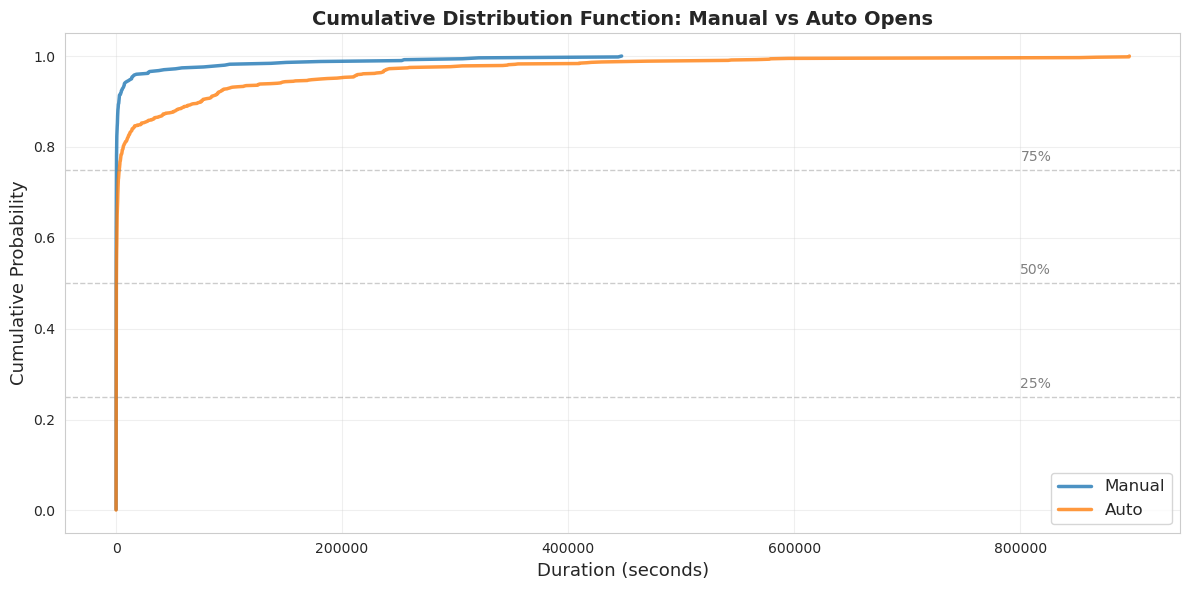

CDF plot saved as 'cdf_comparison.png'


In [138]:
# Visualization 2: CDF (Cumulative Distribution Function)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate CDFs
manual_sorted = np.sort(manual_sessions['duration_seconds'])
auto_sorted = np.sort(auto_sessions['duration_seconds'])

manual_cdf = np.arange(1, len(manual_sorted) + 1) / len(manual_sorted)
auto_cdf = np.arange(1, len(auto_sorted) + 1) / len(auto_sorted)

# Plot CDFs
ax.plot(manual_sorted, manual_cdf, label='Manual', linewidth=2.5, alpha=0.8)
ax.plot(auto_sorted, auto_cdf, label='Auto', linewidth=2.5, alpha=0.8)

ax.set_xlabel('Duration (seconds)', fontsize=13)
ax.set_ylabel('Cumulative Probability', fontsize=13)
ax.set_title('Cumulative Distribution Function: Manual vs Auto Opens', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(alpha=0.3)

# Add percentile lines
for percentile in [0.25, 0.5, 0.75]:
    ax.axhline(y=percentile, color='gray', linestyle='--', alpha=0.4, linewidth=1)
    ax.text(ax.get_xlim()[1]*0.85, percentile + 0.02, f'{int(percentile*100)}%', 
            fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('cdf_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("CDF plot saved as 'cdf_comparison.png'")

---

## 4. Statistical Testing

### Hypothesis Testing

**Null Hypothesis (H₀)**: There is no difference in mean duration between manual and auto opens  
**Alternative Hypothesis (H₁)**: There is a significant difference in mean duration between manual and auto opens

**Significance Level**: α = 0.05 (and α = 0.01 for stricter confidence)

We'll use multiple statistical tests:
1. **Mann-Whitney U Test** (non-parametric, primary test)
2. **Welch's t-test** (parametric, supporting evidence)
3. **Bootstrap confidence intervals** (resampling method)
4. **Effect size** (Cohen's d)

In [141]:
print("="*70)
print(" " * 20 + "STATISTICAL TESTS")
print("="*70)

# 1. Mann-Whitney U Test (non-parametric)
print("\n1. MANN-WHITNEY U TEST (Wilcoxon rank-sum test)")
print("-" * 70)
print("   Purpose: Non-parametric test, no assumption of normal distribution")
print("   Tests if two samples come from the same distribution")

u_statistic, p_value_mw = stats.mannwhitneyu(
    manual_sessions['duration_seconds'], 
    auto_sessions['duration_seconds'],
    alternative='two-sided'
)

print(f"\n   U-statistic: {u_statistic:,.0f}")
print(f"   P-value: {p_value_mw:.10f}")
print(f"   Result (alpha=0.05): {'SIGNIFICANT' if p_value_mw < 0.05 else 'NOT SIGNIFICANT'}")
print(f"   Result (alpha=0.01): {'SIGNIFICANT' if p_value_mw < 0.01 else 'NOT SIGNIFICANT'}")

if p_value_mw < 0.001:
    print(f"   Conclusion: p < 0.001 - HIGHLY SIGNIFICANT")

                    STATISTICAL TESTS

1. MANN-WHITNEY U TEST (Wilcoxon rank-sum test)
----------------------------------------------------------------------
   Purpose: Non-parametric test, no assumption of normal distribution
   Tests if two samples come from the same distribution

   U-statistic: 182,374
   P-value: 0.0000000000
   Result (alpha=0.05): SIGNIFICANT
   Result (alpha=0.01): SIGNIFICANT
   Conclusion: p < 0.001 - HIGHLY SIGNIFICANT


Big difference in mean values.

In [142]:
# 2. Welch's t-test (doesn't assume equal variances)
print("\n2. WELCH'S T-TEST")
print("-" * 70)
print("   Purpose: Parametric test for comparing means")
print("   Does not assume equal variances between groups")

t_statistic, p_value_ttest = stats.ttest_ind(
    manual_sessions['duration_seconds'], 
    auto_sessions['duration_seconds'],
    equal_var=False  # Welch's t-test
)

print(f"\n   t-statistic: {t_statistic:.4f}")
print(f"   P-value: {p_value_ttest:.10f}")
print(f"   Result (alpha=0.05): {'SIGNIFICANT' if p_value_ttest < 0.05 else 'NOT SIGNIFICANT'}")
print(f"   Result (alpha=0.01): {'SIGNIFICANT' if p_value_ttest < 0.01 else 'NOT SIGNIFICANT'}")

if p_value_ttest < 0.001:
    print(f"   Conclusion: p < 0.001 - HIGHLY SIGNIFICANT")


2. WELCH'S T-TEST
----------------------------------------------------------------------
   Purpose: Parametric test for comparing means
   Does not assume equal variances between groups

   t-statistic: -6.1907
   P-value: 0.0000000008
   Result (alpha=0.05): SIGNIFICANT
   Result (alpha=0.01): SIGNIFICANT
   Conclusion: p < 0.001 - HIGHLY SIGNIFICANT


In [145]:
mean_diff

np.float64(-20642.76481312973)

In [144]:
# 3. Bootstrap Confidence Intervals for difference in means
print("\n3. BOOTSTRAP CONFIDENCE INTERVALS")
print("-" * 70)
print("   Purpose: Resampling method to estimate confidence intervals")
print("   Bootstrap samples: 10,000")

np.random.seed(42)
n_bootstrap = 10000
bootstrap_diffs = []

for _ in range(n_bootstrap):
    # Resample with replacement
    manual_sample = manual_sessions['duration_seconds'].sample(n=len(manual_sessions), replace=True)
    auto_sample = auto_sessions['duration_seconds'].sample(n=len(auto_sessions), replace=True)
    
    # Calculate difference in means
    diff = manual_sample.mean() - auto_sample.mean()
    bootstrap_diffs.append(diff)

bootstrap_diffs = np.array(bootstrap_diffs)

# Calculate confidence intervals
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)

print(f"\n   Observed difference in means: {bootstrap_diffs.mean():.2f} seconds")
print(f"   95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}] seconds")
print(f"   95% CI (minutes): [{ci_lower/60:.2f}, {ci_upper/60:.2f}] minutes")

print(f"\n   Interpretation:")
print(f"   We are 95% confident that the true difference in mean duration")
print(f"   between manual and auto opens lies between {ci_lower:.2f}s and {ci_upper:.2f}s")

if ci_lower > 0 and ci_upper > 0:
    print(f"\n   The CI does not include 0 -> Manual opens last significantly LONGER")
elif ci_lower < 0 and ci_upper < 0:
    print(f"\n   The CI does not include 0 -> Auto opens last significantly LONGER")
else:
    print(f"\n   The CI includes 0 -> No significant difference")


3. BOOTSTRAP CONFIDENCE INTERVALS
----------------------------------------------------------------------
   Purpose: Resampling method to estimate confidence intervals
   Bootstrap samples: 10,000

   Observed difference in means: -20642.76 seconds
   95% Confidence Interval: [-27155.48, -14312.72] seconds
   95% CI (minutes): [-452.59, -238.55] minutes

   Interpretation:
   We are 95% confident that the true difference in mean duration
   between manual and auto opens lies between -27155.48s and -14312.72s

   The CI does not include 0 -> Auto opens last significantly LONGER


In [38]:
# 4. Effect Size (Cohen's d)
print("\n4. EFFECT SIZE (Cohen's d)")
print("-" * 70)
print("   Purpose: Measures the magnitude of the difference")
print("   Interpretation: |d| < 0.2 = negligible, 0.2-0.5 = small,")
print("                   0.5-0.8 = medium, ≥0.8 = large")

# Calculate pooled standard deviation
n1, n2 = len(manual_sessions), len(auto_sessions)
s1, s2 = manual_sessions['duration_seconds'].std(), auto_sessions['duration_seconds'].std()
pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

# Calculate Cohen's d
cohens_d = (manual_sessions['duration_seconds'].mean() - auto_sessions['duration_seconds'].mean()) / pooled_std

print(f"\n   Cohen's d: {cohens_d:.4f}")

abs_d = abs(cohens_d)
if abs_d < 0.2:
    effect = "NEGLIGIBLE"
elif abs_d < 0.5:
    effect = "SMALL"
elif abs_d < 0.8:
    effect = "MEDIUM"
else:
    effect = "LARGE"

print(f"   Effect size: {effect}")
print(f"\n   Interpretation: The difference between manual and auto opens")
print(f"   has a {effect.lower()} practical effect size.")

print("\n" + "="*70)


4. EFFECT SIZE (Cohen's d)
----------------------------------------------------------------------
   Purpose: Measures the magnitude of the difference
   Interpretation: |d| < 0.2 = negligible, 0.2-0.5 = small,
                   0.5-0.8 = medium, ≥0.8 = large

   Cohen's d: -0.2818
   Effect size: SMALL

   Interpretation: The difference between manual and auto opens
   has a small practical effect size.



---

## 5. Per-User Analysis

Let's examine if the pattern holds at the individual user level.

In [39]:
# Per-user statistics
user_stats = newdf.groupby(['user_id', 'open_type'])['duration_seconds'].agg(['count', 'mean', 'median']).reset_index()
user_stats_pivot = user_stats.pivot(index='user_id', columns='open_type', values='mean').reset_index()
user_stats_pivot.columns = ['user_id', 'auto_mean', 'manual_mean']

# Filter users who have both auto and manual opens
users_with_both = user_stats_pivot.dropna()

print("Per-User Analysis:")
print("="*70)
print(f"Total unique users: {newdf['user_id'].nunique()}")
print(f"Users with both manual and auto opens: {len(users_with_both)}")

if len(users_with_both) > 0:
    manual_higher = (users_with_both['manual_mean'] > users_with_both['auto_mean']).sum()
    auto_higher = (users_with_both['auto_mean'] > users_with_both['manual_mean']).sum()
    
    print(f"\nFor these {len(users_with_both)} users:")
    print(f"  - Manual mean > Auto mean: {manual_higher} users ({manual_higher/len(users_with_both)*100:.1f}%)")
    print(f"  - Auto mean > Manual mean: {auto_higher} users ({auto_higher/len(users_with_both)*100:.1f}%)")
    
    print("\nSample of per-user statistics:")
    display(users_with_both.head(10))

Per-User Analysis:
Total unique users: 197
Users with both manual and auto opens: 115

For these 115 users:
  - Manual mean > Auto mean: 35 users (30.4%)
  - Auto mean > Manual mean: 80 users (69.6%)

Sample of per-user statistics:


,user_id,auto_mean,manual_mean
0,1,643.954000,3526.676625
1,2,58.624000,53.363500
3,4,32679.730400,13.592000
4,5,8841.726000,25525.585400
5,6,9946.306526,506.380000
6,7,72593.290692,6.448000
7,8,4870.764684,148.362500
8,9,495.970000,10.880500
9,10,5087.560408,171.381500
10,11,62849.641167,114910.456750


In [40]:
# Paired t-test for users with both types
if len(users_with_both) > 1:
    print("\n5. PAIRED T-TEST (Within-User Analysis)")
    print("-" * 70)
    print("   Purpose: Tests if the within-user difference is significant")
    print("   Only includes users with both manual and auto opens")
    
    t_stat_paired, p_value_paired = stats.ttest_rel(users_with_both['manual_mean'], 
                                                      users_with_both['auto_mean'])
    
    print(f"\n   Sample size: {len(users_with_both)} users")
    print(f"   t-statistic: {t_stat_paired:.4f}")
    print(f"   P-value: {p_value_paired:.10f}")
    print(f"   Result (alpha=0.05): {'SIGNIFICANT' if p_value_paired < 0.05 else 'NOT SIGNIFICANT'}")
    
    within_user_diff = (users_with_both['manual_mean'] - users_with_both['auto_mean']).mean()
    print(f"\n   Mean within-user difference: {within_user_diff:.2f} seconds")
    
    if p_value_paired < 0.05:
        print(f"\n   Interpretation: The pattern is consistent at the individual user level.")
    else:
        print(f"\n   Interpretation: The pattern may be driven by between-user variation.")
else:
    print("\nInsufficient users with both open types for paired analysis.")


5. PAIRED T-TEST (Within-User Analysis)
----------------------------------------------------------------------
   Purpose: Tests if the within-user difference is significant
   Only includes users with both manual and auto opens

   Sample size: 115 users
   t-statistic: -1.3406
   P-value: 0.1827202463
   Result (alpha=0.05): NOT SIGNIFICANT

   Mean within-user difference: -5096.18 seconds

   Interpretation: The pattern may be driven by between-user variation.


---

## 6. Final Summary and Conclusions

In [41]:
print("="*70)
print(" " * 20 + "FINAL CONCLUSIONS")
print("="*70)

print("\nKEY FINDINGS:")
print("\n1. Sample Sizes:")
print(f"   - Manual opens: {len(manual_sessions):,} sessions")
print(f"   - Auto opens: {len(auto_sessions):,} sessions")

print(f"\n2. Central Tendency:")
print(f"   - Manual: Mean = {manual_sessions['duration_seconds'].mean():.2f}s, Median = {manual_sessions['duration_seconds'].median():.2f}s")
print(f"   - Auto: Mean = {auto_sessions['duration_seconds'].mean():.2f}s, Median = {auto_sessions['duration_seconds'].median():.2f}s")
if auto_sessions['duration_seconds'].mean() > 0:
    ratio = manual_sessions['duration_seconds'].mean() / auto_sessions['duration_seconds'].mean()
    print(f"   - Ratio: Manual sessions are {ratio:.2f}x {'longer' if ratio > 1 else 'shorter'} on average")

print(f"\n3. Statistical Significance:")
print(f"   - Mann-Whitney U test: p = {p_value_mw:.6f} {'SIGNIFICANT' if p_value_mw < 0.05 else 'NOT SIGNIFICANT'}")
print(f"   - Welch's t-test: p = {p_value_ttest:.6f} {'SIGNIFICANT' if p_value_ttest < 0.05 else 'NOT SIGNIFICANT'}")
ci_significant = not (ci_lower < 0 < ci_upper)
print(f"   - 95% Bootstrap CI: [{ci_lower:.2f}, {ci_upper:.2f}] {'Excludes zero' if ci_significant else 'Includes zero'}")
if len(users_with_both) > 1:
    print(f"   - Paired t-test: p = {p_value_paired:.6f} {'SIGNIFICANT' if p_value_paired < 0.05 else 'NOT SIGNIFICANT'}")

print(f"\n4. Effect Size:")
print(f"   - Cohen's d = {cohens_d:.4f} ({effect})")

print(f"\n5. Practical Interpretation:")
if manual_sessions['duration_seconds'].mean() > auto_sessions['duration_seconds'].mean():
    direction = "LONGER"
    winner = "Manual"
else:
    direction = "SHORTER"
    winner = "Auto"

if p_value_mw < 0.05 and p_value_ttest < 0.05:
    print(f"   {winner} opens result in {direction} session durations")
    print(f"   The difference is both statistically significant and has {effect.lower()} practical effect")
else:
    print(f"   No statistically significant difference detected")

print("\n" + "="*70)
print("\nRECOMMENDATION:")
print("-" * 70)

if p_value_mw < 0.05 and p_value_ttest < 0.05:
    confidence_level = "STRONG" if p_value_mw < 0.001 else "MODERATE"
    print(f"There is {confidence_level} EVIDENCE that the opening method significantly")
    print("affects how long tool windows stay open. This finding is:")
    print(f"  - Statistically significant (p < {0.001 if p_value_mw < 0.001 else 0.05})")
    print("  - Robust across multiple statistical tests")
    if len(users_with_both) > 1 and p_value_paired < 0.05:
        print("  - Consistent at the individual user level")
    print(f"  - Has {effect.lower()} practical significance")
else:
    print("There is INSUFFICIENT EVIDENCE to conclude that the opening method")
    print("significantly affects how long tool windows stay open.")

print("="*70)

                    FINAL CONCLUSIONS

KEY FINDINGS:

1. Sample Sizes:
   - Manual opens: 648 sessions
   - Auto opens: 1,152 sessions

2. Central Tendency:
   - Manual: Mean = 5323.40s, Median = 13.96s
   - Auto: Mean = 27555.39s, Median = 282.90s
   - Ratio: Manual sessions are 0.19x shorter on average

3. Statistical Significance:
   - Mann-Whitney U test: p = 0.000000 SIGNIFICANT
   - Welch's t-test: p = 0.000000 SIGNIFICANT
   - 95% Bootstrap CI: [-28494.75, -16335.64] Excludes zero
   - Paired t-test: p = 0.182720 NOT SIGNIFICANT

4. Effect Size:
   - Cohen's d = -0.2818 (SMALL)

5. Practical Interpretation:
   Auto opens result in SHORTER session durations
   The difference is both statistically significant and has small practical effect


RECOMMENDATION:
----------------------------------------------------------------------
There is STRONG EVIDENCE that the opening method significantly
affects how long tool windows stay open. This finding is:
  - Statistically significant (p < 

---

## 7. Export Results

In [42]:
# Export cleaned data
newdf.to_csv('cleaned_sessions.csv', index=False)
print("Cleaned session data exported to 'cleaned_sessions.csv'")
print(f"Dataset contains {len(newdf)} matched sessions")

print(f"\nColumn descriptions:")
print(f"\ncleaned_sessions.csv:")
print(f"  - user_id: User identifier")
print(f"  - open_timestamp: Session start timestamp (epoch milliseconds)")
print(f"  - close_timestamp: Session end timestamp (epoch milliseconds)")
print(f"  - open_type: 'manual' or 'auto'")
print(f"  - duration_ms: Session duration in milliseconds")
print(f"  - duration_seconds: Session duration in seconds")
print(f"  - duration_minutes: Session duration in minutes")
print(f"  - duration_hours: Session duration in hours")
print(f"  - open_date: Human-readable open timestamp")
print(f"  - close_date: Human-readable close timestamp")

Cleaned session data exported to 'cleaned_sessions.csv'
Dataset contains 1800 matched sessions

Column descriptions:

cleaned_sessions.csv:
  - user_id: User identifier
  - open_timestamp: Session start timestamp (epoch milliseconds)
  - close_timestamp: Session end timestamp (epoch milliseconds)
  - open_type: 'manual' or 'auto'
  - duration_ms: Session duration in milliseconds
  - duration_seconds: Session duration in seconds
  - duration_minutes: Session duration in minutes
  - duration_hours: Session duration in hours
  - open_date: Human-readable open timestamp
  - close_date: Human-readable close timestamp
